In [70]:
import torch
import torch.nn.functional as F

In [71]:
#흔히쓰는 torch함수 내부 확장판과 원리
#model={#sequential,
        #batchnorm1d
        #tanh}

In [72]:
words = open('names.txt','r').read().splitlines()
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)} #i+1 인이유 enumerate의 첫 index - 0이고 이를 시작토큰 .으로 설정
stoi['.'] = 0
itos = {i+1:s for i,s in enumerate(chars)} # {i:s for i,s in stoi.items()} 도 가능
itos[0] = '.'
itos
#데이터셋 만들기
block_size = 3 #context length 몇개의 알파벳을 다음문자를 예측하기 위해 쓸거냐
def build_dataset(words):
  x,y=[],[]
  for w in words:
    context = [0] * block_size
    for ch in w + '.':                #olivia [0,0,0]
      ix =stoi[ch]                    #           o,  l,  i,  v,  i,  a
      x.append(context)               #[[0,0,0]] ...,..o,.ol,oli,liv,iva,...
      y.append(ix)                    #[15] <= olivia 의 stoi가 들어감
      context = context[1:] +[ix]     # 값전달 list
  #build_dataset(words[:3])
  #
  x=torch.tensor(x)
  y=torch.tensor(y)
  print(x.shape,y.shape)

  return x,y

build_dataset(words[:3])

import random
random.seed(42)
random.shuffle(words)

n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

xtr,ytr = build_dataset(words[:n1])
xval, yval = build_dataset(words[n1:n2])
xtest, ytest = build_dataset(words[n2:])


torch.Size([16, 3]) torch.Size([16])
torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [73]:
class Linear:

  #parameter
  def __init__(self,fanin,fanout,bias =True):
    self.weight = torch.randn((fanin,fanout),generator = g)/ fanin**0.5
    #fanout 은 hidden layer뉴런개수
    #fanin 은 input의 가공된 tensor
    self.bias = torch.randn((fanout)) if bias else None

  #linear 안에서 벌어지는 일
  def __call__(self,x):
    self.out = x @ self.weight
    if self.bias is not None:
      self.out += self.bias
    return self.out

  #backprop을 위한 parameter 등록
  def parameter(self):
    return [self.weight] + ([] if self.bias is None else [self.bias])

#----------------------------------------------------------------------

class batchnorm1d:

  def __init__(self,dim,eps=1e-5,momentum=0.1):
    # eps 는 batchnorm 과정중 분모가 0이 되는 걸 막는 작은값

    self.eps =  eps
    self.momentum = momentum
    self.training = True
    #parameter

    #gamma 값이 1인 이유= 직선식에서 ax+b 부분의 a부분이기 때문 초기화 값 당연히 1
    #beta 값이 1인이유 = 직선식에서 ax+b 부분의 b부분의 초기화 값이기 때문
    #gamma beta는 scale shift를 위한것 다양한 값을 선택하기 위함
    #gaussian 분포의 x,y축으로의 움직임

    self.gamma = torch.ones(dim)
    self.beta = torch.zeros(dim)

    #buffer
    #위와비슷 초기 mean이 0으로 선택되면 고려x
    #variance또한 마찬가지 1로 설정되면 고려x
    self.runningmean = torch.zeros(dim)
    self.runningvar= torch.ones(dim)

  def __call__(self,x):

    if self.training:
      xmean = x.mean(0,keepdim=True)  #batchmean
      xvar =x.var(0,keepdim=True,unbiased=True)   #batchvariance
    else:
      xmean = self.runningmean
      xvar= self.runningvar

    xhat=(x-xmean)/torch.sqrt(self.eps+xvar) #actiavationm,batchnorm.ipynb
    self.out = self.gamma*xhat + self.beta

    #buffer 업데이트  momentum comes into play & gradient descent 영향을 받지않음
    #부드럽게 업데이트할 수 있으며, 훈련 초기에는 높은 학습률을 유지함
    #훈련이 진행될수록 이동 평균이 더 중요해지게 됨

    #전체 데이터셋 평균,분산만 사용하는게 아니라 학습하며 얻은정보도 활용
    if self.training:
      with torch.no_grad():
        self.runningmean =  (1-self.momentum)*self.runningmean + self.mementum*xmean
        self.runningvar = (1-self.momentum)*self.runningvar + self.momentum*xvar
    return self.out

    def parameter(self):
      return [self.gamma,self.beta ]

#----------------------------------------------------------------------------------

class tanh:
  def __call__(self,x):
    self.out = torch.tanh(x)
    return self.out

  def parameter(self):
    return []

n_embedding = 10
block_size = 3
vocab_size = 27
n_hidden = 200
g= torch.Generator().manual_seed(2147483647)

C= torch.randn((vocab_size,n_embedding),generator=g)

layers = [
  Linear(n_embedding*block_size,n_hidden),tanh(),
  Linear(              n_hidden,n_hidden),tanh(),
  Linear(              n_hidden,n_hidden),tanh(),
  Linear(              n_hidden,n_hidden),tanh(),
  Linear(              n_hidden,n_hidden),tanh(),
  Linear(              n_hidden,vocab_size),
]

with torch.no_grad():
  #마지막 layer less confident
  layers[-1].weight *= 0.1
  #모든 layer에 gain 적용 -> linear layer값의 std조정에 영향
  for layer in layers:
    if isinstance(layer,Linear):
      layer.weight *= 5/3 ################## 밑의 plt 그래프와 연관 # *= 5/3으로 바꿔보자

parameters =  [C] + [p for layer in layers for p in layer.parameter()]
#tanh, linear의 모든 parameter 개수
print(sum(p.nelement() for p in parameters))
for p in parameters:
  p.requires_grad= True


172697


In [75]:
max_step = 100000
batch_size = 32
lossi = []
ud= [] # update to data ratio gradient descent 가 data 에 얼마나 영향을 주었는가

#
#-----------------------------------------------------------
for i in range(max_step):

  idx = torch.randint(0,xtr.shape[0],(batch_size,),generator = g)
  xb,yb = xtr[idx],ytr[idx]

  #forward pass
#--------------------------------------------------------------------------

  emb = C[xb]
  # xb shape = 32,3 C shape = 27,10 C가 뭐였냐 -> embedding matrix
  #emb shape = 32,3,10 pytorch의 tensor 에 tensor index 원리? 몰루
  x = emb.view(emb.shape[0],-1)
  # emb.shape[0] = 32 즉 x shape = 32,30
  #x (batch_size, block_size*n_embedding)
  for layer in layers:
    x = layer(x)
  loss = F.cross_entropy(x,yb)

  #backward pass
#--------------------------------------------------------------------------

  #gradient 가 순전파 forward passm,역전파 backward pass 계속 쌓여서
  # tensor 의 gradient과정을 역추적 과정 디버깅에 사용
  #메모리 사용량이 매우 증가할수 있음!

  #for layer in layers:
    #layer.out.retain_grad()
  for p in parameters:
    p.grad = None
  loss.backward()



  #update
#---------------------------------------------------------------------------

    #update learnining rate
  lr = 0.1 if i < 100000 else 0.01
  #학습률 조절 초기엔 빠르게 갈수록 안정적으로
  for p in parameters:
    p.data += -lr * p.grad



  if i % 10000 == 0:
    print(f'{i:7d}/{max_step:7d}: {loss.item():.4f}')
  lossi.append(loss.log10().item())
  with torch.no_grad():
    ud.append([(lr*p.grad.std() / p.data.std()).log10().item() for p in parameters])


      0/ 100000: 2.2806
  10000/ 100000: 2.2824
  20000/ 100000: 2.0250
  30000/ 100000: 1.7667
  40000/ 100000: 2.0652
  50000/ 100000: 2.2083
  60000/ 100000: 2.0344
  70000/ 100000: 1.9219
  80000/ 100000: 2.1893
  90000/ 100000: 2.0367


In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(20,4))
legends=[]
for i,layer in enumerate(layers[:-1]): #마지막 output tanh만 뺴고
  if isinstance(layer,tanh):
    t= layer.out
    print('layer %d (%10s): mean %+.2f,std %.2f, saturated: %2.f%%'%(i,layer.__class__.__name__,t.mean(),t.std(),(t.abs()>0.97).float().mean()*100))
    hy,hx = torch.histogram(t,density=True)
    plt.plot(hx[:-1].detach(),hy.detach())
    legends.append(f'layer {i}({layer.__class__.__name__}')
plt.legend(legends);
plt.title('activation distribution')

#activation distribution이 일정한이유 5/3 / sqrt(fan_in)을 곱해줬기 떄문

In [ ]:

plt.figure(figsize=(20,4))
legends=[]
for i,layer in enumerate(layers[:-1]): #마지막 output tanh만 뺴고
  if isinstance(layer,Linear):
    t= layer.out
    print('layer %d (%10s): mean %+.2f,std %.2f, saturated: %2.f%%'%(i,layer.__class__.__name__,t.mean(),t.std(),(t.abs()>0.97).float().mean()*100))
    hy,hx = torch.histogram(t,density=True)
    plt.plot(hx[:-1].detach(),hy.detach())
    legends.append(f'layer {i}({layer.__class__.__name__}')
plt.legend(legends);
plt.title('gradient distribution')

#activation distribution이 일정한이유 5/3 / sqrt(fan_in)을 곱해줬기 떄문

In [84]:
%Ismagic


UsageError: Line magic function `%Ismagic` not found.


[-3.1149544715881348, -2.8835744857788086, -2.945765256881714, -3.0312328338623047, -2.944469690322876, -3.0233709812164307, -2.9708962440490723, -3.071819305419922, -3.0169126987457275, -2.938849925994873, -2.8710520267486572, -2.9028685092926025, -3.0047953128814697, -3.0966310501098633, -3.0226099491119385, -3.0891430377960205, -3.063098907470703, -2.991844892501831, -3.0119502544403076, -3.147771120071411, -2.8624308109283447, -2.995561122894287, -3.007434606552124, -2.98795485496521, -2.969177722930908, -2.9355194568634033, -2.93477463722229, -3.053905725479126, -3.058906078338623, -3.0205655097961426, -2.8909659385681152, -2.954313039779663, -2.908761978149414, -2.9714415073394775, -2.9788339138031006, -2.9342665672302246, -3.045276403427124, -2.9963462352752686, -3.049517869949341, -2.9788784980773926, -3.093327283859253, -3.12241792678833, -2.923672914505005, -3.103017807006836, -3.098405599594116, -3.0479202270507812, -3.004265308380127, -3.0506751537323, -2.9253196716308594, 

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



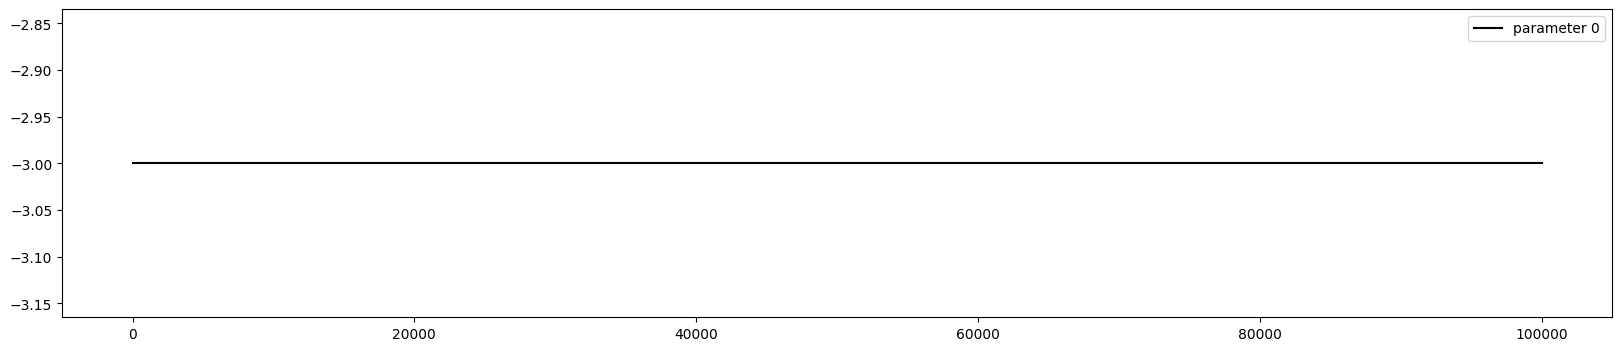

In [81]:
%matplotlib inline
plt.figure(figsize=(20,4))
legends= []
for i, p in enumerate(parameters):
  if p.ndim ==2: # weight를 의미
  # ud.append([(lr*p.grad.std() / p.data.std()).log10().item() for p in parameters])
    print([ud[j][i] for j in range(len(ud))])
  # weight의 update data 비율만을 출력한다는 뜻
    legends.append('parameter %d' % i)
plt.plot([0,len(ud)],[-3,-3],'k')
plt.legend(legends);